# **IEOR E4650  Business Analytics (Fall 2019)**

##**Lecture 8: Censoring**

In this lecture, we discuss how to model censoring in the data

Learning objective:

* Understand the censoring in the data
* Understand how to model censoring in the data
* Understand how to use AIC/BIC to measure model fit



##Censoring


Censoring happens when the outcome value is not completely known. Censoring is a common problem in the business analytics, as in many settings the exact number cannot be collect or simply does not exist. 

Example 1: We track our customers to see for how many days they will keep on purchasing our organic egg before switching to our competitor. However, maybe by the end of our study period, some customers still have not switched. 

Example 2: In a survey, we ask customers how many times they have seen our advertisement by using a dropoff down questions, which gives 0, 1, 2, 3, 4, and 4+.




##Fishing dataset
In the following study, we have the visitors report how many fish they caught during their visit. The data in the original data is not censored. 

However, there are cases, we simply ask the visitor report the following

Fish caught: 0, 1, 2, 3, 4, 5, more than 5 (recorded as 6)

In this case, we then have a censoring problem, because 6 means the visitor actually caught at least 6 fish. However, the exact number is simply not known. 

If this is the case, how do we model the outcomes?

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link="https://drive.google.com/open?id=1ytZ6QqLH-ES1YxxYbOGwMERVep0Tkhgu"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('myfile.csv')  
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import scipy.stats as spst
from scipy.optimize import minimize
import scipy.special as spsp


Fishing = pd.read_csv('myfile.csv')
Fishing.head(10)


,livebait,child,persons,camper,Nfish
0,0,0,1,0,0
1,1,0,1,1,0
2,1,0,1,0,0
3,1,1,2,1,0
4,1,0,1,0,1
5,1,2,4,1,0
6,1,1,3,0,0
7,1,3,4,0,0
8,0,2,3,1,0
9,1,0,1,1,1


Let's create a column thats censored.

In [0]:
Fishing["Nfish"].values

array([  0,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   1,
         2,   0,   1,   0,   0,   1,   0,   1,   5,   0,   3,  30,   0,
        13,   0,   0,   0,   0,   0,  11,   5,   0,   1,   1,   7,   0,
        14,   0,  32,   0,   1,   0,   0,   0,   1,   5,   0,   1,   0,
        22,   0,  15,   0,   0,   0,   5,   4,   2,   0,   2,  32,   0,
         0,   1,   0,   0,   0,   7,   0,   0,   0,   0,   0,   0,   0,
         0,   2,   3,   1,   5,   0,   2,   1,   0,   1, 149,   0,   1,
         0,   0,   1,   0,   0,   0,   2,   2,  29,   3,   0,   0,   5,
         0,   0,   0,   0,   0,   1,   7,   1,   0,   2,   0,   2,   0,
         0,   0,   1,   0,   0,   0,   0,   0,   3,   4,   3,   3,   8,
         2,   1,   6,   0,   0,   5,   3,  31,   0,   2,   0,   0,   0,
         0,   0,   0,   6,   9,   0,   0,   0,   0,   0,   2,  15,   1,
         2,   3,   0,  65,   5,   0,   0,   0,   0,   1,   8,   0,   0,
         0,   2,   4,   5,   9,   0,   0,   0,   0,  21,   0,   

In [0]:
#Let's create a censored column that record 6 for Nfish>5
N_fish=Fishing["Nfish"].copy().values
N_fish[N_fish>5]=6
Fishing=Fishing.assign(Nfish_c=N_fish)
Fishing["Nfish"].values

array([  0,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,   0,   1,
         2,   0,   1,   0,   0,   1,   0,   1,   5,   0,   3,  30,   0,
        13,   0,   0,   0,   0,   0,  11,   5,   0,   1,   1,   7,   0,
        14,   0,  32,   0,   1,   0,   0,   0,   1,   5,   0,   1,   0,
        22,   0,  15,   0,   0,   0,   5,   4,   2,   0,   2,  32,   0,
         0,   1,   0,   0,   0,   7,   0,   0,   0,   0,   0,   0,   0,
         0,   2,   3,   1,   5,   0,   2,   1,   0,   1, 149,   0,   1,
         0,   0,   1,   0,   0,   0,   2,   2,  29,   3,   0,   0,   5,
         0,   0,   0,   0,   0,   1,   7,   1,   0,   2,   0,   2,   0,
         0,   0,   1,   0,   0,   0,   0,   0,   3,   4,   3,   3,   8,
         2,   1,   6,   0,   0,   5,   3,  31,   0,   2,   0,   0,   0,
         0,   0,   0,   6,   9,   0,   0,   0,   0,   0,   2,  15,   1,
         2,   3,   0,  65,   5,   0,   0,   0,   0,   1,   8,   0,   0,
         0,   2,   4,   5,   9,   0,   0,   0,   0,  21,   0,   

## Baseline Model

First, let's pretend that the data is not censored. 

Let's try to fit a zero-inflated NBD model. 

Here, we are fitting a zero-inflated model, because some visitors might not fish at all.

For the NBD part, we would like to consider the fact that consumers might have different $\lambda$. 

1. The number of fish caught within a unit time can depend on different factors, for example, whether the person has kids, the type of bait used, etc.  

2. Especially, in this case, we might not expect the actual fishing time for each visitor is the same. Having NBD model also allows us to capture the differences in the fishing time. [the fishing time will follow a distribution]

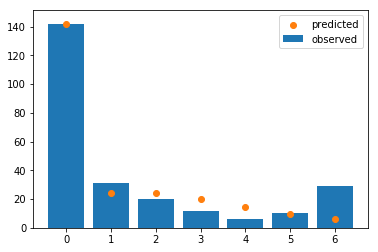

In [0]:
y=Fishing["Nfish_c"].values
def Neg_LL(betas):
  gamma=np.exp(betas[0])
  alpha=np.exp(betas[1])
  p=np.exp(betas[2])/(1+np.exp(betas[2]))
  #the individual likelihood for segment 1
  Ind_L1=spsp.gamma(gamma+y)/spsp.gamma(gamma)/spsp.gamma(y+1)\
  *(1/(1+alpha))**y*(alpha/(1+alpha))**gamma
  #the individual likelihood for segment 2
  Ind_L2=spst.poisson.pmf(y,0)
  #individual likelihood
  Ind_L=Ind_L1*p+Ind_L2*(1-p)
  Ind_LL=np.log(Ind_L)
  return -np.sum(Ind_LL)

#estimate the model
guess=np.random.rand(3)
model1=minimize(Neg_LL,guess, method="BFGS")
betas=model1.x

#recover the paramters
gamma=np.exp(betas[0])
alpha=np.exp(betas[1])
p=np.exp(betas[2])/(1+np.exp(betas[2]))

#compute the predicted visitors having 0, 1, 2,... fish.
outcomes=np.arange(0, np.max(y+1))
pmf1=spsp.gamma(gamma+outcomes)/spsp.gamma(gamma)/spsp.gamma(outcomes+1)*(1/(alpha+1))**outcomes*(alpha/(alpha+1))**gamma
pmf=pmf1*p+spst.poisson.pmf(outcomes,0)*(1-p)
prediction=pmf*250 

#compute the observed number of visitors having 0, 1, 2,... fish.
Tally=Fishing.groupby(["Nfish_c"]).count()
#visualization
plt.bar(Tally.index.values,Tally.iloc[:,0].values,label="observed")
plt.scatter(outcomes,prediction,zorder=2,label="predicted")
plt.legend(loc="best")
plt.show()

##Modeling Censoring

For censoring problem, we need to think about the probability of observing an outcome that is being censored. 

In this case, we should assign a different likelihood for the 6+ case. It is nothing but the probability of catching more than 5 fish. 
$P(x \geq 6)=1-\sum_{i=0}^5P(i)=1-CDF(x=5)$


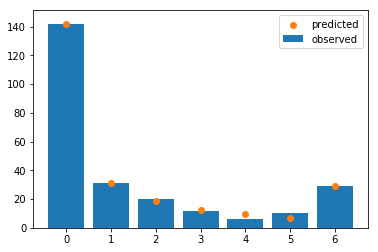

In [0]:
y=Fishing["Nfish_c"].values
def Neg_LL(betas):
  gamma=np.exp(betas[0])
  alpha=np.exp(betas[1])
  p=np.exp(betas[2])/(1+np.exp(betas[2]))
  #the individual likelihood for segment 1
  Ind_L1=spsp.gamma(gamma+y)/spsp.gamma(gamma)/spsp.gamma(y+1)*(1/(alpha+1))**y*(alpha/(alpha+1))**gamma
  #reassign likelihood for visitors with 6+ exposures
  outcomes=np.arange(0,6)
  PMFs=spsp.gamma(gamma+outcomes)/spsp.gamma(gamma)/spsp.gamma(outcomes+1)*(1/(alpha+1))**outcomes*(alpha/(alpha+1))**gamma
  Ind_L1[y==6]=1-np.sum(PMFs)
  #individual likelihood
  Ind_L=Ind_L1*p+spst.poisson.pmf(y,0)*(1-p)
  Ind_LL=np.log(Ind_L)
  return -np.sum(Ind_LL)

#estimate the model
guess=np.random.rand(3)
model2=minimize(Neg_LL,guess, method="BFGS")
betas=model2.x

#recover the paramters
gamma=np.exp(betas[0])
alpha=np.exp(betas[1])
p=np.exp(betas[2])/(1+np.exp(betas[2]))

#compute the predicted visitors having 0, 1, 2,... fish.
outcomes=np.arange(0, np.max(y+1))
pmf1=spsp.gamma(gamma+outcomes)/spsp.gamma(gamma)/spsp.gamma(outcomes+1)*(1/(alpha+1))**outcomes*(alpha/(alpha+1))**gamma
#reassign pmf for visitors with 6 exposures
outcomes=np.arange(0,6)
PMFs=spsp.gamma(gamma+outcomes)/spsp.gamma(gamma)/spsp.gamma(outcomes+1)*(1/(alpha+1))**outcomes*(alpha/(alpha+1))**gamma
pmf1[6]=1-np.sum(PMFs)
outcomes=np.arange(0, np.max(y+1))
pmf=pmf1*p+spst.poisson.pmf(outcomes,0)*(1-p)
prediction=pmf*250 

#compute the observed number of visitors having 0, 1, 2,... fish.
Tally=Fishing.groupby(["Nfish_c"]).count()
#visualization
plt.bar(Tally.index.values,Tally.iloc[:,0].values,label="observed")
plt.scatter(outcomes,prediction,zorder=2,label="predicted")
plt.legend(loc="best")
plt.show()

Let's take a look at the model prediction v.s actual uncensored data. 

Our censored model does a superb job recovering the actual out comes even though the data was originally censored. 

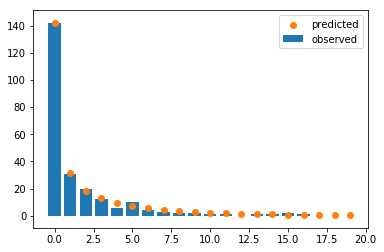

In [0]:
outcomes=np.arange(0, np.max(Fishing["Nfish"]+1))
pmf=spsp.gamma(gamma+outcomes)/spsp.gamma(gamma)/spsp.gamma(outcomes+1)*(1/(alpha+1))**outcomes*(alpha/(alpha+1))**gamma*p+spst.poisson.pmf(outcomes,0)*(1-p)
prediction=pmf*250 

Tally=Fishing.groupby(["Nfish"]).count()
plt.bar(Tally.index.values[Tally.index.values<20],Tally.iloc[:,0].values[Tally.index.values<20],label="observed")
plt.scatter(outcomes[outcomes<20],prediction[outcomes<20],zorder=2,label="predicted")
plt.legend(loc="best")
plt.show()


##Model comparison

Besides Cross-validation, one thing that is commonly used to measure the model fit are AKaike Information Criterion (AIC) and Baysian Information Criterion (BIC).

$$AIC=-2JointLogLikelihood+2k$$
$$BIC=-2JointLogLikelihood+klog(n)$$

Where $k$ is the number of parameters we estimated, whie $n$ is the number of observations we have. 

We can see that generally BIC penalizes free parameters more strongly than AIC. It is usually suggested we report both AIC and BIC for the models we estimate. Similar to $R^2$ and adjusted $R^2$, the AIC/BIC are only comparable for two models if two models are estimating the same outcome variables. 

We will prefer to have a model that has lower AIC/BIC. 



In [0]:
#model.fun -jointloglikelihood
#joint log likelihood
-model1.fun

386.1260664580844

In [0]:
#AIC model 1
2*model1.fun+2*3

778.2521329161688

In [0]:
#BIC model1
2*model1.fun+3*np.log(250)

788.8165156697555

In [0]:
#AIC model 2
2*model2.fun+2*3

706.6323029002435

In [0]:
#BIC model2
2*model2.fun+3*np.log(250)

717.1966856538303